In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image

# Bibliotecas do Keras que usaremos
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [2]:
import os

# Verificar se o diretório existe
DATA_DIR = "data/PetImages"
print(f"Diretório especificado: {DATA_DIR}")
print(f"Diretório existe: {os.path.exists(DATA_DIR)}")

# Listar conteúdo do diretório atual
print("Conteúdo do diretório atual:")
for item in os.listdir('.'):
    print(f"  {item}")

# Verificar caminho absoluto
absolute_path = os.path.abspath(DATA_DIR)
print(f"Caminho absoluto: {absolute_path}")
print(f"Diretório absoluto existe: {os.path.exists(absolute_path)}")

# Listar subdiretórios se o diretório existir
if os.path.exists(DATA_DIR):
    print("Subdiretórios encontrados:")
    try:
        subdirs = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
        for subdir in subdirs:
            print(f"  {subdir}")
    except Exception as e:
        print(f"Erro ao listar subdiretórios: {e}")

Diretório especificado: data/PetImages
Diretório existe: True
Conteúdo do diretório atual:
  classificador_pets.ipynb
  data
  Include
  Lib
  pyvenv.cfg
  script.py
  Scripts
  share
Caminho absoluto: c:\Users\Lipez800\Desktop\Projeto_dio\Versao_inicial_do_classificador_de_caes_e_gatos\venv_deeplearning\data\PetImages
Diretório absoluto existe: True
Subdiretórios encontrados:
  Cat
  Dog


In [3]:
# Célula 2 (VERSÃO ATUALIZADA)

import os
from PIL import Image
import re

# Função para limpar e normalizar nomes de arquivos
def sanitize_filename(filename):
    # Remove acentos e caracteres especiais
    # Normaliza para 'NFKD' que separa o caractere da acentuação
    # e depois codifica/decodifica para remover o que não for ASCII.
    import unicodedata
    sanitized = unicodedata.normalize('NFKD', filename).encode('ascii', 'ignore').decode('ascii')
    # Substitui espaços e outros separadores por underscore
    sanitized = re.sub(r'[\s\(\)\[\]]+', '_', sanitized)
    # Remove caracteres que não sejam letras, números, underscore ou ponto.
    sanitized = re.sub(r'[^a-zA-Z0-9_.]+', '', sanitized)
    return sanitized.lower()

# Script principal de limpeza 
data_dir = "data/PetImages"
subfolders = ["Cat", "Dog"]
img_type_accepted_by_tf = ["jpeg", "jpg", "png"]  # Adicionei mais formatos

print("Iniciando limpeza completa do dataset (nomes e conteúdo)...")
total_renamed = 0
total_removed = 0

for folder_name in subfolders:
    folder_path = os.path.join(data_dir, folder_name)
    if not os.path.exists(folder_path):
        print(f"Aviso: Pasta não encontrada: {folder_path}")
        continue

    # Cria uma lista de arquivos para iterar para não dar problema ao renomear
    files_to_process = os.listdir(folder_path)

    for fname in files_to_process:
        original_fpath = os.path.join(folder_path, fname)
        
        # 1. Limpa o nome do arquivo
        sanitized_fname = sanitize_filename(fname)
        
        # Se o nome mudou, renomeia o arquivo
        if sanitized_fname != fname.lower():
            new_fpath = os.path.join(folder_path, sanitized_fname)
            # Evita sobrescrever um arquivo que já existe
            if os.path.exists(new_fpath):
                print(f"Arquivo já existente, pulando renomeação: {new_fpath}")
                # Remove o arquivo original para evitar duplicatas
                try:
                    os.remove(original_fpath)
                    total_removed += 1
                except Exception as e:
                    print(f"Erro ao remover arquivo duplicado: {original_fpath}. Erro: {e}")
                continue
            
            try:
                os.rename(original_fpath, new_fpath)
                current_fpath = new_fpath
                total_renamed += 1
            except Exception as e:
                print(f"Erro ao renomear arquivo: {original_fpath}. Erro: {e}")
                continue
        else:
            current_fpath = original_fpath

        # 2. Verifica se a imagem é válida (COM FECHAMENTO CORRETO)
        try:
            with Image.open(current_fpath) as img:
                if img.format is None or img.format.lower() not in img_type_accepted_by_tf:
                    img.close()  # Fecha explicitamente
                    os.remove(current_fpath)
                    total_removed += 1
                    continue
                # img.verify() pode causar problemas, vamos usar um método mais seguro
                img.load()  # Carrega a imagem para verificar se é válida
            # Arquivo é fechado automaticamente pelo 'with'
            
        except Exception as e:
            print(f"Removendo arquivo inválido: {current_fpath}. Erro: {e}")
            try:
                os.remove(current_fpath)
                total_removed += 1
            except Exception as remove_error:
                print(f"Erro ao remover arquivo: {remove_error}")

print(f"\nLimpeza concluída.")
print(f"Total de arquivos renomeados: {total_renamed}")
print(f"Total de arquivos removidos (corrompidos ou duplicados): {total_removed}")

Iniciando limpeza completa do dataset (nomes e conteúdo)...

Limpeza concluída.
Total de arquivos renomeados: 0
Total de arquivos removidos (corrompidos ou duplicados): 0


In [4]:
import os
import tensorflow as tf

# Parâmetros do dataset
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32
DATA_DIR = "data/PetImages"  # ou o caminho correto

# Verificação do diretório
print(f"Diretório de dados: {DATA_DIR}")
print(f"Existe: {os.path.exists(DATA_DIR)}")

if not os.path.exists(DATA_DIR):
    print("❌ ERRO: Diretório não encontrado!")
    print("Por favor, verifique se a estrutura de pastas está correta:")
    print("data/PetImages/Cat/  e  data/PetImages/Dog/")
else:
    # Listar subdiretórios
    subdirs = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
    print(f"Subdiretórios encontrados: {subdirs}")
    
    if len(subdirs) == 0:
        print("❌ Nenhum subdiretório encontrado em PetImages")
    else:
        print("✅ Diretório configurado corretamente")

# Carregar dados usando image_dataset_from_directory
try:
    print("Carregando datasets de treino e validação...")
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE)

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE)
        
    print("✅ Datasets carregados com sucesso!")
    
except Exception as e:
    print(f"❌ Erro ao carregar datasets: {e}")

Diretório de dados: data/PetImages
Existe: True
Subdiretórios encontrados: ['Cat', 'Dog']
✅ Diretório configurado corretamente
Carregando datasets de treino e validação...
Found 1983 files belonging to 2 classes.
Using 1587 files for training.
Found 1983 files belonging to 2 classes.
Using 396 files for validation.
✅ Datasets carregados com sucesso!


Carregando datasets de treino e validação...
Found 1983 files belonging to 2 classes.
Using 1587 files for training.
Found 1983 files belonging to 2 classes.
Using 396 files for validation.
Classes encontradas: ['Cat', 'Dog']


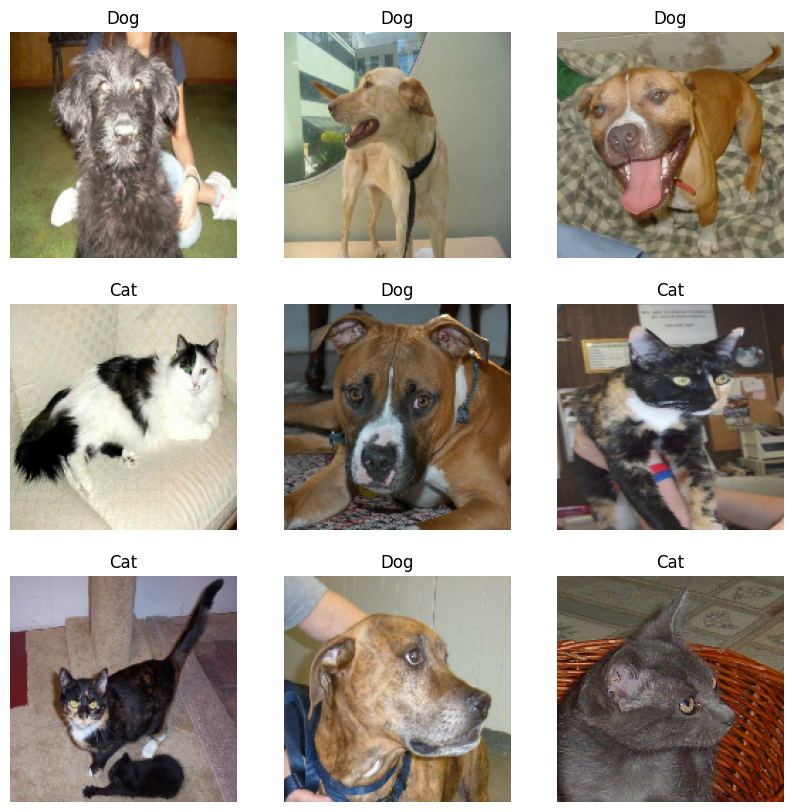

In [5]:
# Parâmetros do dataset
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32
DATA_DIR = "data/PetImages"

# Carregar dados usando image_dataset_from_directory
print("Carregando datasets de treino e validação...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

# ✅ LINHA QUE FALTAVA: Obter os nomes das classes
class_names = train_dataset.class_names
print("Classes encontradas:", class_names)

# Agora pode usar class_names normalmente
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])  # Agora vai funcionar!
        plt.axis("off")
plt.show()

In [6]:
# Cria uma camada de pré-processamento para normalizar os pixels
# MobileNetV2 espera pixels no intervalo [-1, 1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Otimiza o pipeline de dados
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

print("Pipeline de dados otimizado e pronto para o treinamento.")

Pipeline de dados otimizado e pronto para o treinamento.


In [7]:
# Definindo a forma da entrada
IMG_SHAPE = IMAGE_SIZE + (3,)

# 1. Carregar o modelo base pré-treinado
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # Não incluir o classificador final do ImageNet
                                               weights='imagenet')

# 2. Congelar os pesos do modelo base
base_model.trainable = False

# 3. Adicionar nossas camadas de classificação
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid') # 1 neurônio para classificação binária (cão ou gato)
])

# 4. Compilar o modelo
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Visualizar a arquitetura do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
import tensorflow as tf

# Verificar versão do TensorFlow
print("TensorFlow version:", tf.__version__)

# Verificar GPUs disponíveis
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

# Verificar se o TensorFlow pode usar GPU
print("Built with CUDA:", tf.test.is_built_with_cuda())

# Verificar se está usando GPU
print("Usando GPU:", tf.test.is_gpu_available())  # Método deprecated mas ainda funciona

# Método mais atualizado:
try:
    print("GPU disponível:", len(tf.config.experimental.list_physical_devices('GPU')) > 0)
except:
    pass

TensorFlow version: 2.19.0
GPUs disponíveis: []
Built with CUDA: False
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Usando GPU: False
GPU disponível: False


In [9]:
# Adicione isso antes do treinamento para ver detalhes
import tensorflow as tf

print("=== Informações do Sistema ===")
print(f"TensorFlow version: {tf.__version__}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

# Listar todos os dispositivos
print("\n=== Dispositivos Disponíveis ===")
for device in tf.config.list_physical_devices():
    print(f"  {device}")

# Verificar especificamente GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPUs encontradas: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu}")
else:
    print("\n⚠️  Nenhuma GPU encontrada - usando CPU")

=== Informações do Sistema ===
TensorFlow version: 2.19.0
Built with CUDA: False

=== Dispositivos Disponíveis ===
  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

⚠️  Nenhuma GPU encontrada - usando CPU


In [10]:
import tensorflow as tf

# Configurações para otimizar o uso da GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Habilitar crescimento de memória (evita usar toda a memória da GPU de uma vez)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configurada com sucesso! GPUs encontradas: {len(gpus)}")
    except RuntimeError as e:
        print(f"Erro na configuração da GPU: {e}")
else:
    print("Nenhuma GPU encontrada. Usando CPU.")

# Seu código de treinamento (já otimizado)
initial_epochs = 10

print(f"Iniciando treinamento por {initial_epochs} épocas...")
print("Dispositivo sendo usado:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    verbose=1  # Mostra progresso detalhado
)

Nenhuma GPU encontrada. Usando CPU.
Iniciando treinamento por 10 épocas...
Dispositivo sendo usado: CPU
Epoch 1/10


50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 801ms/step - accuracy: 0.4993 - loss: 0.8040 - val_accuracy: 0.6944 - val_loss: 0.6109
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 742ms/step - accuracy: 0.6747 - loss: 0.5787 - val_accuracy: 0.8207 - val_loss: 0.4508
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 726ms/step - accuracy: 0.8177 - loss: 0.4245 - val_accuracy: 0.8864 - val_loss: 0.3494
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 737ms/step - accuracy: 0.8941 - loss: 0.3330 - val_accuracy: 0.9343 - val_loss: 0.2808
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 758ms/step - accuracy: 0.9191 - loss: 0.2853 - val_accuracy: 0.9394 - val_loss: 0.2362
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 715ms/step - accuracy: 0.9255 - loss: 0.2456 - val_accuracy: 0.9495 - val_loss: 0.2032
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 716ms/step - accuracy: 0.9462 - loss: 0.2084 - val_accuracy: 0.9571 - val_loss: 0.1785
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 713ms/step - accuracy: 0.9530 - loss: 0.1725 - val_accuracy: 0.962

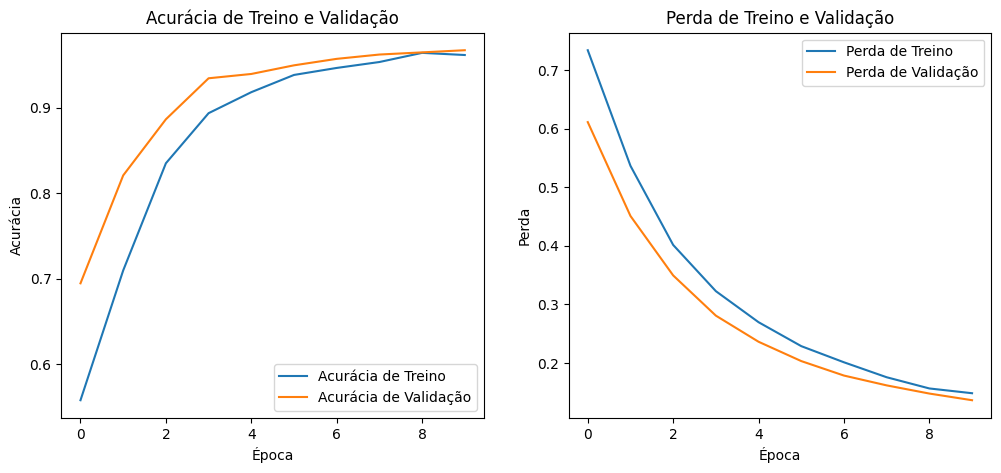

In [11]:
# CORRIGIDO: Use 'val_accuracy' e 'val_loss' em vez de 'validation_accuracy' e 'validation_loss'
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # ✅ Corrigido
loss = history.history['loss']
val_loss = history.history['val_loss']      # ✅ Corrigido

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(initial_epochs), acc, label='Acurácia de Treino')
plt.plot(range(initial_epochs), val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(range(initial_epochs), loss, label='Perda de Treino')
plt.plot(range(initial_epochs), val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.xlabel('Época')
plt.ylabel('Perda')

plt.show()